## Generate Background Notebook

This notebook generates background images that can be feed to galaxycluster.py 
@marcoc7, last edited 1/28/2025

In [31]:
#import relevant libaries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.table import Table
from astropy.io import fits

%load_ext autoreload


import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"
spherex_path = base_dir / "SPHEREx"

sys.path.append(str(autolens_config_path))
sys.path.append(str(spherex_path))


#import gcluster15  # from autolens_config
import SPHERExScripts as SPHEREx  # from SPHEREX
import gcluster15 as galaxy
import autolens_config


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2

### Part 1: Creating a relevant data set for this project

Open merged catalog (filtered for galaxies only), filter for relevant redshift ranges, output new table


In [7]:
#Open merged table (@ James, this file is only accessible on Rabbit!)
#cat = Table.read('/home/marco/fits_files/processed_master_v6-1.fits')
cat = Table.read('/home/marco/lsHEROESmergedv2') #This table should appear in both computers? Maybe not, I will check it later shrug

#/home/marco/lsHEROESmergedv2.fits

In [8]:
cat
#23,482,097 objects in table, should all be galaxies

ra_heroes,dec_heroes,ra_ls,dec_ls,from,ls_id,hsc_id,type,i_ap2,i_ap2err,i_kron,i_kronerr,z_ap2,z_ap2err,z_kron,z_kronerr,flux_z,mag_z,snr_z,y_ap2,y_ap2err,y_kron,y_kronerr,n816_ap2,n816_ap2err,n816_kron,n816_kronerr,n921_ap2,n921_ap2err,n921_kron,n921_kronerr,mag_w1,flux_w1,snr_w1,mag_w2,flux_w2,snr_w2,mag_w3,flux_w3,snr_w3,mag_w4,flux_w4,snr_w4,x,y,xx,yy,xy,patch,wise_coadd_id,brickid,brickname,sersic,shape_r,shape_e1,shape_e2,ellipticity,theta,sc_id
float64,float64,float64,float64,bytes6,int64,int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,bytes5,bytes8,int64,bytes8,float64,float64,float64,float64,float64,float64,int64
278.53500138043825,63.9749665047913,--,--,HEROES,--,158913789953,--,--,--,--,--,23.559645,0.21461079,--,--,--,--,--,-23.850363,0.7138585,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19949.146,59448.258,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.54114302999335,63.97458600247457,--,--,HEROES,--,158913789954,--,--,--,--,--,24.353443,0.44712862,23.963285,0.24130464,--,--,--,23.672665,0.61583346,25.028233,1.6664253,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19890.473,59448.87,3.136412,3.7544372,1.5408987,"1,5",--,--,--,--,--,--,--,--,--,--
278.53467936808585,63.98020507322936,--,--,HEROES,--,158913789960,--,--,--,--,--,23.596027,0.21847671,23.608713,0.2265859,--,--,--,23.064314,0.2341843,23.138815,0.26028684,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19969.445,59559.27,2.9423282,7.981417,-2.4735303,"1,5",--,--,--,--,--,--,--,--,--,--
278.54366208675265,63.979596966488785,--,--,HEROES,--,158913789961,--,--,--,--,--,24.422678,0.47287714,24.341719,0.3389037,--,--,--,23.07018,0.34841648,23.06124,0.26967525,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19883.473,59559.066,3.3169792,1.5757403,-0.9627106,"1,5",--,--,--,--,--,--,--,--,--,--
278.557056527257,63.98110038446475,--,--,HEROES,--,158913789966,--,--,--,--,--,23.784037,0.2651253,23.840254,0.2155417,--,--,--,23.326906,0.4468022,23.219593,0.31476638,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19763.244,59610.066,3.554889,4.4261637,-2.4642541,"1,5",--,--,--,--,--,--,--,--,--,--
278.5660856348791,63.98054121651192,--,--,HEROES,--,158913789967,--,--,--,--,--,--,--,--,--,--,--,--,21.020847,0.05430802,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19677.0,59611.0,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.5422704450695,63.982163849010426,--,--,HEROES,--,158913789968,--,--,--,--,--,23.621317,0.22423156,--,--,--,--,--,23.831797,0.47693807,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19904.959,59611.71,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.562633433481,63.982529692938314,--,--,HEROES,--,158913789971,--,--,--,--,--,23.6037,0.22494477,23.531757,0.20944446,--,--,--,23.072655,0.35450727,23.254608,0.41856563,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19715.848,59648.402,1.097193,3.530041,1.078596,"1,5",--,--,--,--,--,--,--,--,--,--
278.5502414378729,63.98346593960416,--,--,HEROES,--,158913789972,--,--,--,--,--,23.061796,0.13471395,23.24774,0.22281943,--,--,--,23.019363,0.33279997,22.713615,0.35374734,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19834.762,59650.727,3.682224,6.6021667,1.3244936,"1,5",--,--,--,--,--,--,--,--,--,--


In [12]:
print(cat.colnames)


['ra_heroes', 'dec_heroes', 'ra_ls', 'dec_ls', 'from', 'ls_id', 'hsc_id', 'type', 'i_ap2', 'i_ap2err', 'i_kron', 'i_kronerr', 'z_ap2', 'z_ap2err', 'z_kron', 'z_kronerr', 'flux_z', 'mag_z', 'snr_z', 'y_ap2', 'y_ap2err', 'y_kron', 'y_kronerr', 'n816_ap2', 'n816_ap2err', 'n816_kron', 'n816_kronerr', 'n921_ap2', 'n921_ap2err', 'n921_kron', 'n921_kronerr', 'mag_w1', 'flux_w1', 'snr_w1', 'mag_w2', 'flux_w2', 'snr_w2', 'mag_w3', 'flux_w3', 'snr_w3', 'mag_w4', 'flux_w4', 'snr_w4', 'x', 'y', 'xx', 'yy', 'xy', 'patch', 'wise_coadd_id', 'brickid', 'brickname', 'sersic', 'shape_r', 'shape_e1', 'shape_e2', 'ellipticity', 'theta', 'sc_id']


In [10]:
#Filtering out stuff: 

tab = cat
#Filters out irrelevant data, masks invalid data, and creates a newTable, called cTable to use for the data processing later in this notebook (saves time)

#Masks out stuff
tab['z_ap2err'] = np.ma.masked_invalid(tab['z_ap2err'])
tab['z_ap2'] = np.ma.masked_invalid(tab['z_ap2'])
tab['snr_z'] = np.ma.masked_invalid(tab['snr_z'])
tab['mag_z'] = np.ma.masked_invalid(tab['mag_z'])

# Define filter conditions
condition1 = (1/tab['z_ap2err'] > 5) & (tab['z_ap2'] > 0) # SUBARU specific filter
condition2 = (tab['snr_z'] > 5) & (tab['mag_z'] > 0) # DESI specific filter

# Handle masked values to ensure they are considered invalid in the conditions
condition1 = condition1.filled(False)
condition2 = condition2.filled(False)

# Combine conditions based on the specified requirements
final_condition = (
    (condition1 & np.ma.getmaskarray(tab['snr_z']) & np.ma.getmaskarray(tab['mag_z'])) |  # Condition 1 valid, Condition 2 invalid
    (condition2 & np.ma.getmaskarray(tab['z_ap2err']) & np.ma.getmaskarray(tab['z_ap2'])) |  # Condition 2 valid, Condition 1 invalid
    (condition1 & condition2)  # Both conditions valid and both pass
)

tab = tab[final_condition]


tab['z_ap2_flux'] = 10**((22.5 - tab['z_ap2']) / 2.5) #Converts AB Mag to nMJy
tab['snr_z_ap2'] = 1/tab['z_ap2err'] #SNR of HEROES Data


#Just a random function I made to create a new data table
def combined_column(tab,new_tab,col1_name, col2_name, combined_col_name):
    '''
    NOTE: IF BOTH COLUMNS HAVE VALID DATA, THEN COLUMN 1 VALUES WILL BE USED!!
    '''
    tab[col1_name] = np.ma.masked_invalid(tab[col1_name])
    tab[col2_name] = np.ma.masked_invalid(tab[col2_name])
        
    new_tab[combined_col_name] = np.where(tab[col1_name].mask, tab[col2_name], tab[col1_name])
    
cTab = Table()

combined_column(tab,cTab,'snr_z','snr_z_ap2','snr_z')
combined_column(tab,cTab,'flux_z','z_ap2_flux','flux_z')

combined_column(tab,cTab,'ra_heroes','ra_ls','ra')
combined_column(tab,cTab,'dec_heroes','dec_ls','dec')
cTab['from'] = tab['from']
cTab['sersic'] = tab['sersic']
cTab['shape_r'] = tab['shape_r']
cTab['ellipticity'] = tab['ellipticity']
cTab['theta'] = tab['theta']
cTab['type'] = tab['type']
cTab['z_ap2'] = tab['z_ap2']
cTab['mag_z'] = tab['mag_z']


print('Compressed Data Table (cTab) HAS BEEN CREATED') 
#Note: There needs to be a better version of this, as if I have to cycle through different bands....(ask Thomas about the photometry table format!)

Compressed Data Table (cTab) HAS BEEN CREATED


In [11]:
cTab

snr_z,flux_z,ra,dec,from,sersic,shape_r,ellipticity,theta,type,z_ap2,mag_z
float64,float64,float64,float64,bytes6,float64,float64,float64,float64,bytes3,float32,float64
7.423136234283447,0.5960483551025391,278.5502414378729,63.98346593960416,HEROES,--,--,--,--,--,23.061796,--
5.824462890625,0.47450974583625793,278.56635461594584,63.98386263607685,HEROES,--,--,--,--,--,23.309387,--
8.229771614074707,0.6526135206222534,278.54468232557014,63.98780203243494,HEROES,--,--,--,--,--,22.96336,--
6.142543315887451,0.4910074770450592,278.5616275588034,63.98965381349078,HEROES,--,--,--,--,--,23.27228,--
7.586978435516357,0.5949039459228516,278.5392191956687,63.991583319762334,HEROES,--,--,--,--,--,23.063883,--
5.520657062530518,0.4495585560798645,278.5824439301725,63.9909842405763,HEROES,--,--,--,--,--,23.368034,--
5.631864547729492,0.4526507556438446,278.57189930902774,63.99198912231289,HEROES,--,--,--,--,--,23.360592,--
6.566609859466553,0.5200942158699036,278.56373989241666,63.99558895428802,HEROES,--,--,--,--,--,23.209795,--
6.589621067047119,0.5362299084663391,278.5912509403485,63.995284997680685,HEROES,--,--,--,--,--,23.176622,--


In [14]:
cTab.write('SPHEREx/fitsFiles/zFluxTableFiltered.fits',format = 'fits',overwrite=True) 
#^This is the compressed table that will be used for the data processing later on in this notebook

#### Actually Make The Image

In [15]:
catalog = Table.read('SPHEREx/fitsFiles/zFluxTableFiltered.fits',format = 'fits')
catalog

snr_z,flux_z,ra,dec,from,sersic,shape_r,ellipticity,theta,type,z_ap2,mag_z
float64,float64,float64,float64,bytes6,float64,float64,float64,float64,bytes3,float32,float64
7.423136234283447,0.5960483551025391,278.5502414378729,63.98346593960416,HEROES,--,--,--,--,--,23.061796,--
5.824462890625,0.47450974583625793,278.56635461594584,63.98386263607685,HEROES,--,--,--,--,--,23.309387,--
8.229771614074707,0.6526135206222534,278.54468232557014,63.98780203243494,HEROES,--,--,--,--,--,22.96336,--
6.142543315887451,0.4910074770450592,278.5616275588034,63.98965381349078,HEROES,--,--,--,--,--,23.27228,--
7.586978435516357,0.5949039459228516,278.5392191956687,63.991583319762334,HEROES,--,--,--,--,--,23.063883,--
5.520657062530518,0.4495585560798645,278.5824439301725,63.9909842405763,HEROES,--,--,--,--,--,23.368034,--
5.631864547729492,0.4526507556438446,278.57189930902774,63.99198912231289,HEROES,--,--,--,--,--,23.360592,--
6.566609859466553,0.5200942158699036,278.56373989241666,63.99558895428802,HEROES,--,--,--,--,--,23.209795,--
6.589621067047119,0.5362299084663391,278.5912509403485,63.995284997680685,HEROES,--,--,--,--,--,23.176622,--


In [ ]:
#Since we want these images in 683, 683 original image size... 
#We will now uses Marco's SPHEREx Scripts to do stuff: 


In [35]:
#Load PSF Data: 
psf,reso_ratio,psf_length = SPHEREx.loadPSFData(filePath = '/home/marco/SPHEREx-ML/SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits')

/home/marco/SPHEREx-ML/SPHEREx/SPHERExScripts.py:20: SyntaxWarning: invalid escape sequence '\p'
  def loadPSFData(filePath = 'SPHEREx\psf_data\simulated_PSF_2DGaussian_1perarray.fits'):
/home/marco/SPHEREx-ML/SPHEREx/SPHERExScripts.py:251: SyntaxWarning: invalid escape sequence '\p'
  '''


In [66]:
#Method 2: W/ Multiprocessing (much faster)

dataTab = catalog

# Load RA and DEC
ra = dataTab['ra']
dec = dataTab['dec']
flux_column = dataTab['flux_z']

#Define Offsets (else random)
#ra_offset = 270
#dec_offset = 66


# Compute min and max values
ra_min, ra_max = np.min(ra), np.max(ra)
dec_min, dec_max = np.min(dec), np.max(dec)

# Shrink the range by 3 degrees from both ends
ra_min_shrunk = ra_min + 3
ra_max_shrunk = ra_max - 3

dec_min_shrunk = dec_min + 3
dec_max_shrunk = dec_max - 3

ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)


#Actually generate image data
raw = SPHEREx.parallel_canvas_generator(ra, 
                                        dec,
                                        flux_column, 
                                        ra_offset = ra_offset,
                                        dec_offset = dec_offset, 
                                        dataTable = catalog, 
                                        reso_ratio = reso_ratio,
                                        psf_length = psf_length,
                                        n_spherex_pix=32, 
                                        n_sections=4)


Edge Sersics Progress:: 100%|██████████| 9/9 [00:00<00:00, 213.02it/s]


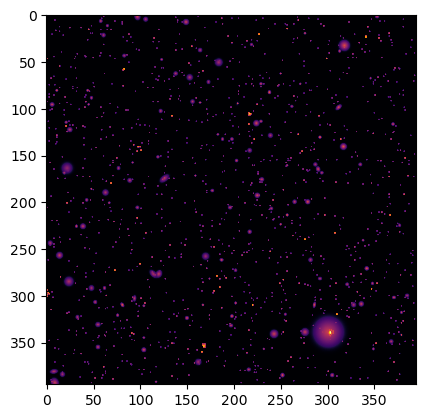

In [67]:
##Plot Image (optional)
import matplotlib as mpl
array = raw
norm = mpl.colors.SymLogNorm(linthresh=0.005, vmin=array.min(), vmax=array.max())
plt.imshow(array, norm=norm, cmap='inferno')


In [63]:
#Loop to generate multiple ones and save as a h5 file: 
# Load RA and DEC
ra = dataTab['ra']
dec = dataTab['dec']
flux_column = dataTab['flux_z']

#Define Offsets (else random)
#ra_offset = 270
#dec_offset = 66


# Compute min and max values
ra_min, ra_max = np.min(ra), np.max(ra)
dec_min, dec_max = np.min(dec), np.max(dec)

# Shrink the range by 3 degrees from both ends
ra_min_shrunk = ra_min + 3
ra_max_shrunk = ra_max - 3

dec_min_shrunk = dec_min + 3
dec_max_shrunk = dec_max - 3

ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)

num_images = 5 
raw_outputs = []

for i in range(num_images):
    ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
    dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)
    raw = SPHEREx.parallel_canvas_generator(ra, 
                                            dec,
                                            flux_column, 
                                            ra_offset = ra_offset,
                                            dec_offset = dec_offset, 
                                            dataTable = catalog, 
                                            reso_ratio = reso_ratio,
                                            psf_length = psf_length,
                                            n_spherex_pix=64, 
                                            n_sections=4)
    print (f'Image {i} generated')
    raw_outputs.append(raw)

Edge Sersics Progress:: 100%|██████████| 21/21 [00:00<00:00, 95.83it/s]


Image 0 generated


Edge Sersics Progress:: 100%|██████████| 13/13 [00:00<00:00, 103.72it/s]


Image 1 generated


Edge Sersics Progress:: 100%|██████████| 19/19 [00:00<00:00, 92.35it/s]


Image 2 generated


Edge Sersics Progress:: 100%|██████████| 12/12 [00:00<00:00, 85.81it/s]


Image 3 generated


Edge Sersics Progress:: 100%|██████████| 11/11 [00:00<00:00, 106.76it/s]

Image 4 generated


In [64]:
import h5py


output_filename = "output/generatedBackgrounds/simulated1.h5"
with h5py.File(output_filename, "w") as hdf:
    hdf.create_dataset("raw_outputs", data=raw_outputs)

### Open h5 file to check if stuff actually saved right

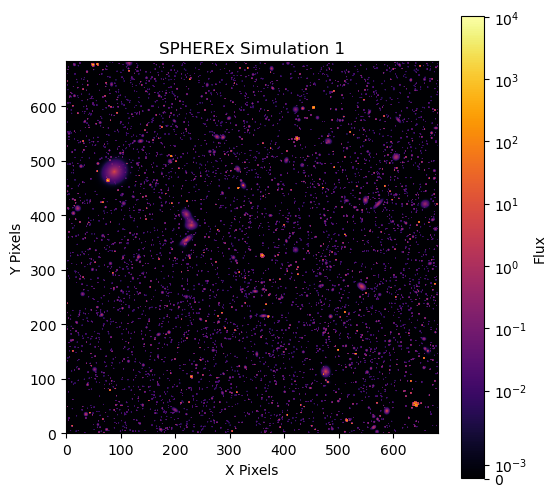

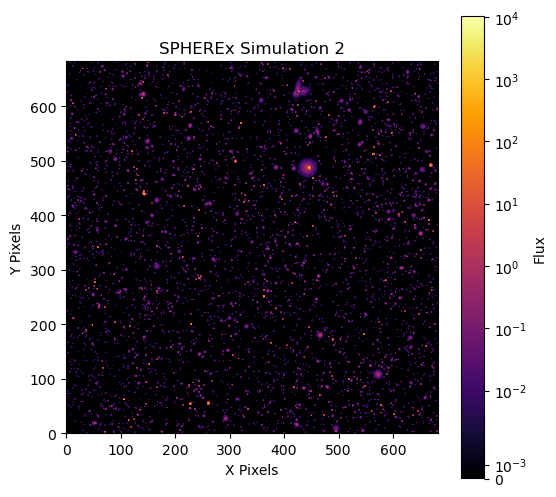

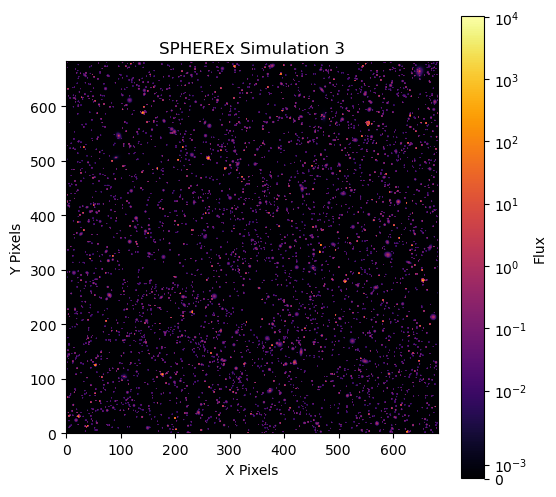

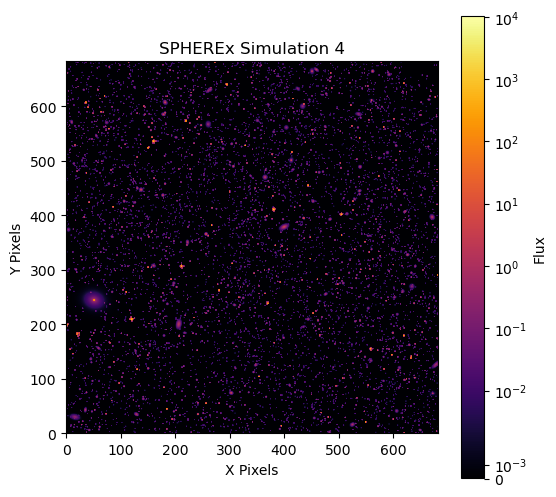

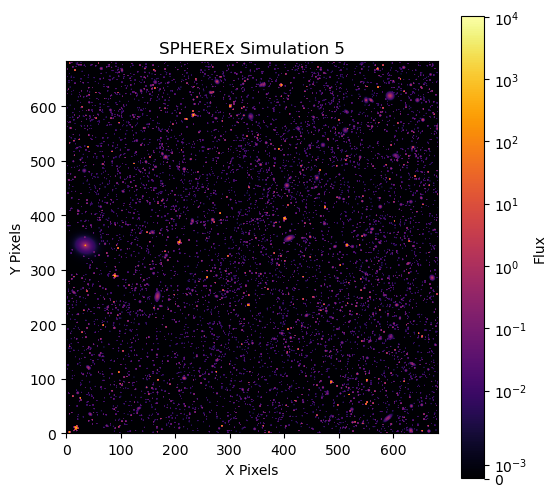

In [65]:
with h5py.File("output/generatedBackgrounds/simulated1.h5", "r") as hdf:
    loaded_data = hdf["raw_outputs"][:]


for i, data in enumerate(loaded_data):
    norm = mpl.colors.SymLogNorm(linthresh=0.005, vmin=array.min(), vmax=array.max())
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='inferno', origin='lower',norm=norm)
    plt.colorbar(label="Flux")
    plt.title(f"SPHEREx Simulation {i+1}")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.show()